# Breast (BRCA) and Cervical (CESC) Cancer Patient Clustering and Mortality Analysis

## Unsupervised Learning: Clustering and Dimensionality Reduction

### Introduction and Motivation

This analysis applies unsupervised learning techniques to identify distinct patient subgroups within breast cancer (BRCA) and cervical cancer (CESC) cohorts from The Cancer Genome Atlas (TCGA) dataset.

**Research Question:** What patient subgroups exist within BRCA and CESC, and how do mortality patterns differ between these cancers?

### Methods Overview

**Dimensionality Reduction**
- **Principal Component Analysis (PCA):** A linear technique that identifies orthogonal axes of maximum variance, transforming correlated features into uncorrelated principal components
- **t-SNE:** A non-linear technique optimized for visualization that preserves local neighborhood structure

**Clustering Methods**
- **K-Means:** Partitions data into k spherical clusters by minimizing within-cluster variance
- **DBSCAN:** Density-based clustering that identifies arbitrarily shaped clusters and labels outliers as noise
- **Hierarchical Clustering:** Builds nested cluster hierarchies

## Import Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Processing

In [124]:
# Load datasets
brca_df = pd.read_csv('data/processed-data/brca/brca-clinical-processed.tsv', sep='\t')
cesc_df = pd.read_csv('data/processed-data/cesc/cesc-clinical-processed.tsv', sep='\t')

# Filter valid survival times
brca_df = brca_df[brca_df['survival_time_days'] >= 0].copy()
cesc_df = cesc_df[cesc_df['survival_time_days'] >= 0].copy()

# Add cancer type identifier
brca_df['cancer_type'] = 'BRCA'
cesc_df['cancer_type'] = 'CESC'

print(f"BRCA samples: {len(brca_df)}")
print(f"CESC samples: {len(cesc_df)}")

def deduplicate_by_treatment(df):
    df['treatments.count'] = df.groupby('cases.submitter_id')['cases.submitter_id'].transform('count')
    treatment_col = df['treatments.treatment_or_therapy'].astype(str).str.lower()
    df['sort_priority'] = (~treatment_col.isin(['true', 'yes'])).astype(int)
    df_sorted = df.sort_values(['cases.submitter_id', 'sort_priority'])
    df_dedup = df_sorted.drop_duplicates(subset=['cases.submitter_id'], keep='first')
    df_dedup = df_dedup.drop('sort_priority', axis=1)
    return df_dedup

brca_dup = deduplicate_by_treatment(brca_df)
cesc_dup = deduplicate_by_treatment(cesc_df)

print(f"BRCA: {len(brca_df)} -> {len(brca_dup)} (removed {len(brca_df) - len(brca_dup)} duplicates)")
print(f"CESC: {len(cesc_df)} -> {len(cesc_dup)} (removed {len(cesc_df) - len(cesc_dup)} duplicates)")

brca_df = brca_dup.copy()
cesc_df = cesc_dup.copy()

BRCA samples: 4920
CESC samples: 872
BRCA: 4920 -> 1081 (removed 3839 duplicates)
CESC: 872 -> 184 (removed 688 duplicates)


### Stage Normalization

BRCA uses AJCC staging while CESC uses FIGO staging. We normalize both to a common ordinal scale (1-4) representing disease severity.

In [125]:
def normalize_ajcc_stage(stage):
    """Normalize AJCC pathologic stage to ordinal severity (1-4)"""
    if pd.isna(stage):
        return 0
    stage = str(stage).lower().strip()
    if any(x in stage for x in ['stage i', 'ia', 'ib']) and 'ii' not in stage:
        return 1
    elif 'stage ii' in stage and 'iii' not in stage:
        return 2
    elif 'stage iii' in stage and 'iv' not in stage:
        return 3
    elif 'stage iv' in stage:
        return 4
    else:
        return 0

def normalize_figo_stage(stage):
    """Normalize FIGO stage to ordinal severity (1-4)"""
    if pd.isna(stage):
        return 0
    stage = str(stage).lower().strip()
    if any(x in stage for x in ['stage i', 'ia', 'ib']) and 'ii' not in stage:
        return 1
    elif 'stage ii' in stage and 'iii' not in stage:
        return 2
    elif 'stage iii' in stage and 'iv' not in stage:
        return 3
    elif 'stage iv' in stage:
        return 4
    else:
        return 0

brca_df['stage_severity'] = brca_df['diagnoses.ajcc_pathologic_stage'].apply(normalize_ajcc_stage)
cesc_df['stage_severity'] = cesc_df['diagnoses.figo_stage'].apply(normalize_figo_stage)

print("BRCA Stage Severity:")
print(brca_df['stage_severity'].value_counts().sort_index())
print("\nCESC Stage Severity:")
print(cesc_df['stage_severity'].value_counts().sort_index())

stage_labels = {0: 'Unknown', 1: 'Stage 1', 2: 'Stage 2', 3: 'Stage 3', 4: 'Stage 4'}
print("\nStage Key: 0=Unknown, 1=Stage 1, 2=Stage 2, 3=Stage 3, 4=Stage 4")

BRCA Stage Severity:
stage_severity
0     15
1    207
2    613
3    246
Name: count, dtype: int64

CESC Stage Severity:
stage_severity
1    117
2     45
3     22
Name: count, dtype: int64

Stage Key: 0=Unknown, 1=Stage 1, 2=Stage 2, 3=Stage 3, 4=Stage 4


## Feature Selection and One Hot Encoding

We select common clinical features and apply one-hot encoding to categorical variables, transforming them into numeric format suitable for distance based algorithms.

In [126]:
common_features = [
    'diagnoses.age_at_diagnosis',
    'demographic.race',
    'demographic.vital_status',
    'survival_time_days',
    'treatments.treatment_or_therapy',
    'treatments.treatment_type',
    'stage_severity',
    'cancer_type'
]

combined_df = pd.concat([brca_df[common_features], cesc_df[common_features]], ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

combined_df['is_deceased'] = (combined_df['demographic.vital_status'].str.lower() == 'dead').astype(int)

categorical_cols = ['demographic.race', 'treatments.treatment_or_therapy', 'treatments.treatment_type']

for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('Unknown')

combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)
print(f"Shape after one-hot encoding: {combined_df_encoded.shape}")

analysis_df = combined_df_encoded.dropna(subset=['diagnoses.age_at_diagnosis', 'survival_time_days', 'cancer_type']).copy()
print(f"Analysis dataset after dropping NA: {len(analysis_df)} samples")

race_cols = [col for col in analysis_df.columns if col.startswith('demographic.race_')]
treatment_cols = [col for col in analysis_df.columns if col.startswith('treatments.treatment_or_therapy_')]
treatment_type_cols = [col for col in analysis_df.columns if col.startswith('treatments.treatment_type_')]

feature_cols = (['diagnoses.age_at_diagnosis', 'stage_severity'] + race_cols + treatment_cols + treatment_type_cols)

X = analysis_df[feature_cols].values
y_cancer = analysis_df['cancer_type'].values
y_deceased = analysis_df['is_deceased'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nFeature matrix shape: {X_scaled.shape}")

feature_names_short = (
    ['Age', 'Stage'] +
    [col.replace('demographic.race_', 'Race:') for col in race_cols] +
    [col.replace('treatments.treatment_or_therapy_', 'Treated:') for col in treatment_cols] +
    [col.replace('treatments.treatment_type_', 'TxType:') for col in treatment_type_cols]
)

Combined dataset shape: (1265, 8)
Shape after one-hot encoding: (1265, 32)
Analysis dataset after dropping NA: 1265 samples

Feature matrix shape: (1265, 28)



# Dimensionality Reduction

Considering the high dimensionality of clinical feature space which had a mix of continuous and one hot encoded variables, we used dimentionality reduction to better understand our data and see if there is separation between cancer types. We used Principal Component Analysis(PCA) and t-distributed Stochastic Neighbor Embedding t-distributed Stochastic Neighbor Embedding(t-NSE) to capture global variance and visualize local neighborhood structure. PCA showed variance was distributed across many components indicating complex variation, 80% percent were distributed to 18 components. We tested multiple perplexities for t-SNE and selected 30 to balance structure in the embedded space.

### Principal Component Analysis (PCA)
**Key hyperparameter:** Number of components to retain (determined by cumulative variance threshold or scree plot)

  PC1: 10.95% (Cumulative: 10.95%)
  PC2: 6.51% (Cumulative: 17.45%)
  PC3: 5.72% (Cumulative: 23.17%)
  PC4: 4.94% (Cumulative: 28.11%)
  PC5: 4.59% (Cumulative: 32.70%)
  PC6: 4.54% (Cumulative: 37.24%)
  PC7: 4.36% (Cumulative: 41.60%)
  PC8: 4.12% (Cumulative: 45.73%)
  PC9: 3.98% (Cumulative: 49.71%)
  PC10: 3.70% (Cumulative: 53.41%)

Components needed for 80% variance: 18


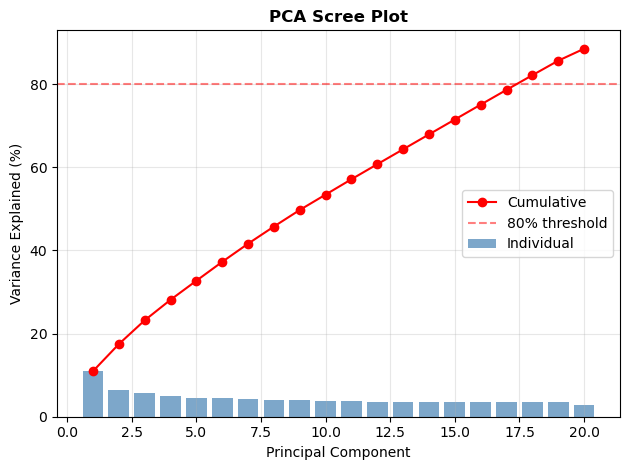

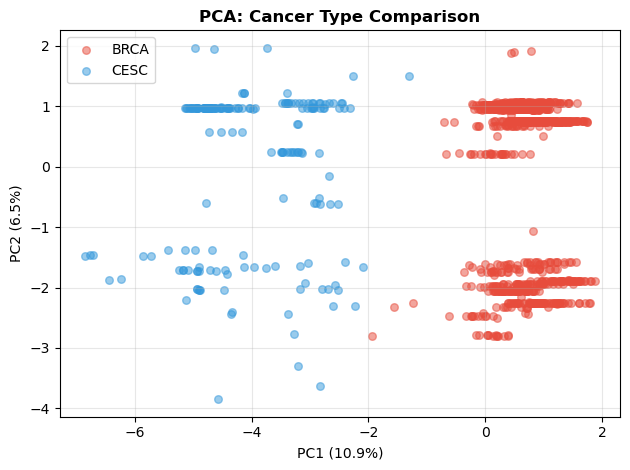

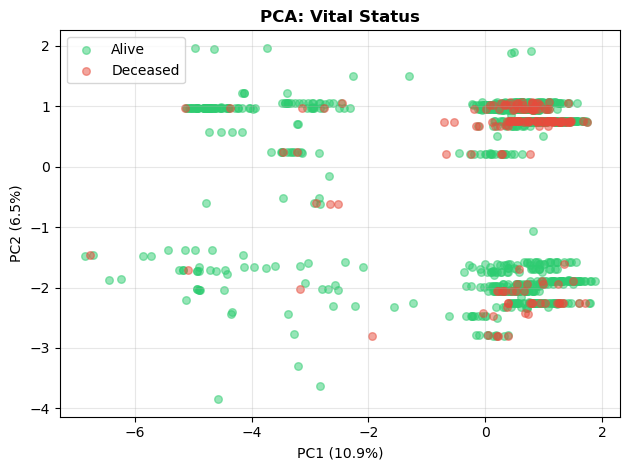

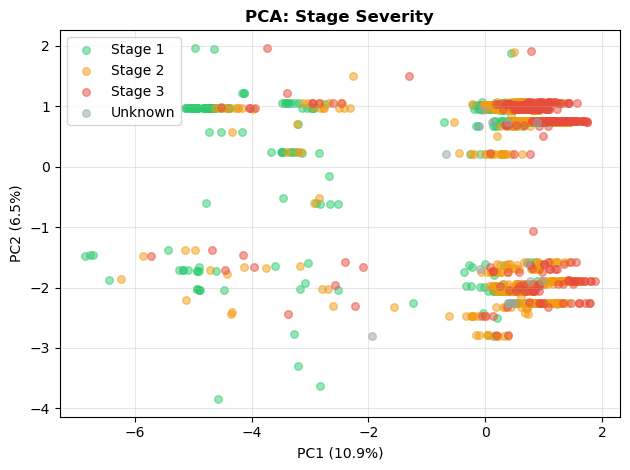

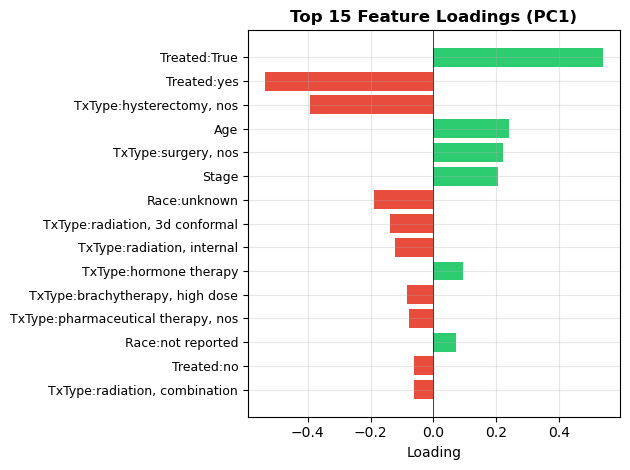

In [127]:
pca_full = PCA()
pca_full.fit(X_scaled)

variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

for i in range(min(10, len(variance_explained))):
    print(f"  PC{i+1}: {variance_explained[i]*100:.2f}% (Cumulative: {cumulative_variance[i]*100:.2f}%)")

n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"\nComponents needed for 80% variance: {n_components_80}")

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots()
components = range(1, min(21, len(variance_explained) + 1))
ax.bar(components, variance_explained[:len(components)] * 100, alpha=0.7, color='steelblue', label='Individual')
ax.plot(components, cumulative_variance[:len(components)] * 100, 'ro-', label='Cumulative')
ax.axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% threshold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('PCA Scree Plot', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

colors_cancer = {'BRCA': '#E74C3C', 'CESC': '#3498DB'}
colors_status = {0: '#2ECC71', 1: '#E74C3C'}
labels_status = {0: 'Alive', 1: 'Deceased'}
colors_stage = {0: '#95A5A6', 1: '#2ECC71', 2: '#F39C12', 3: '#E74C3C', 4: '#8E44AD'}

fig, ax = plt.subplots()
for cancer in ['BRCA', 'CESC']:
    mask = y_cancer == cancer
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors_cancer[cancer], label=cancer, alpha=0.5, s=30)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)')
ax.set_title('PCA: Cancer Type Comparison', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
for status in [0, 1]:
    mask = y_deceased == status
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors_status[status], label=labels_status[status], alpha=0.5, s=30)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)')
ax.set_title('PCA: Vital Status', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
for stage in [1, 2, 3, 4, 0]:
    mask = analysis_df['stage_severity'].values == stage
    if mask.sum() > 0:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors_stage[stage], label=stage_labels[stage], alpha=0.5, s=30)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)')
ax.set_title('PCA: Stage Severity', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
loadings_pc1 = pca.components_[0]
top_n = 15
top_idx = np.argsort(np.abs(loadings_pc1))[-top_n:]
top_loadings = loadings_pc1[top_idx]
top_names = [feature_names_short[i] for i in top_idx]

colors_loading = ['#E74C3C' if x < 0 else '#2ECC71' for x in top_loadings]
ax.barh(range(top_n), top_loadings, color=colors_loading)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_names, fontsize=9)
ax.set_xlabel('Loading')
ax.set_title('Top 15 Feature Loadings (PC1)', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### t-SNE
**Key hyperparameter:** Perplexity (effective number of neighbors; typical range: 5-50)

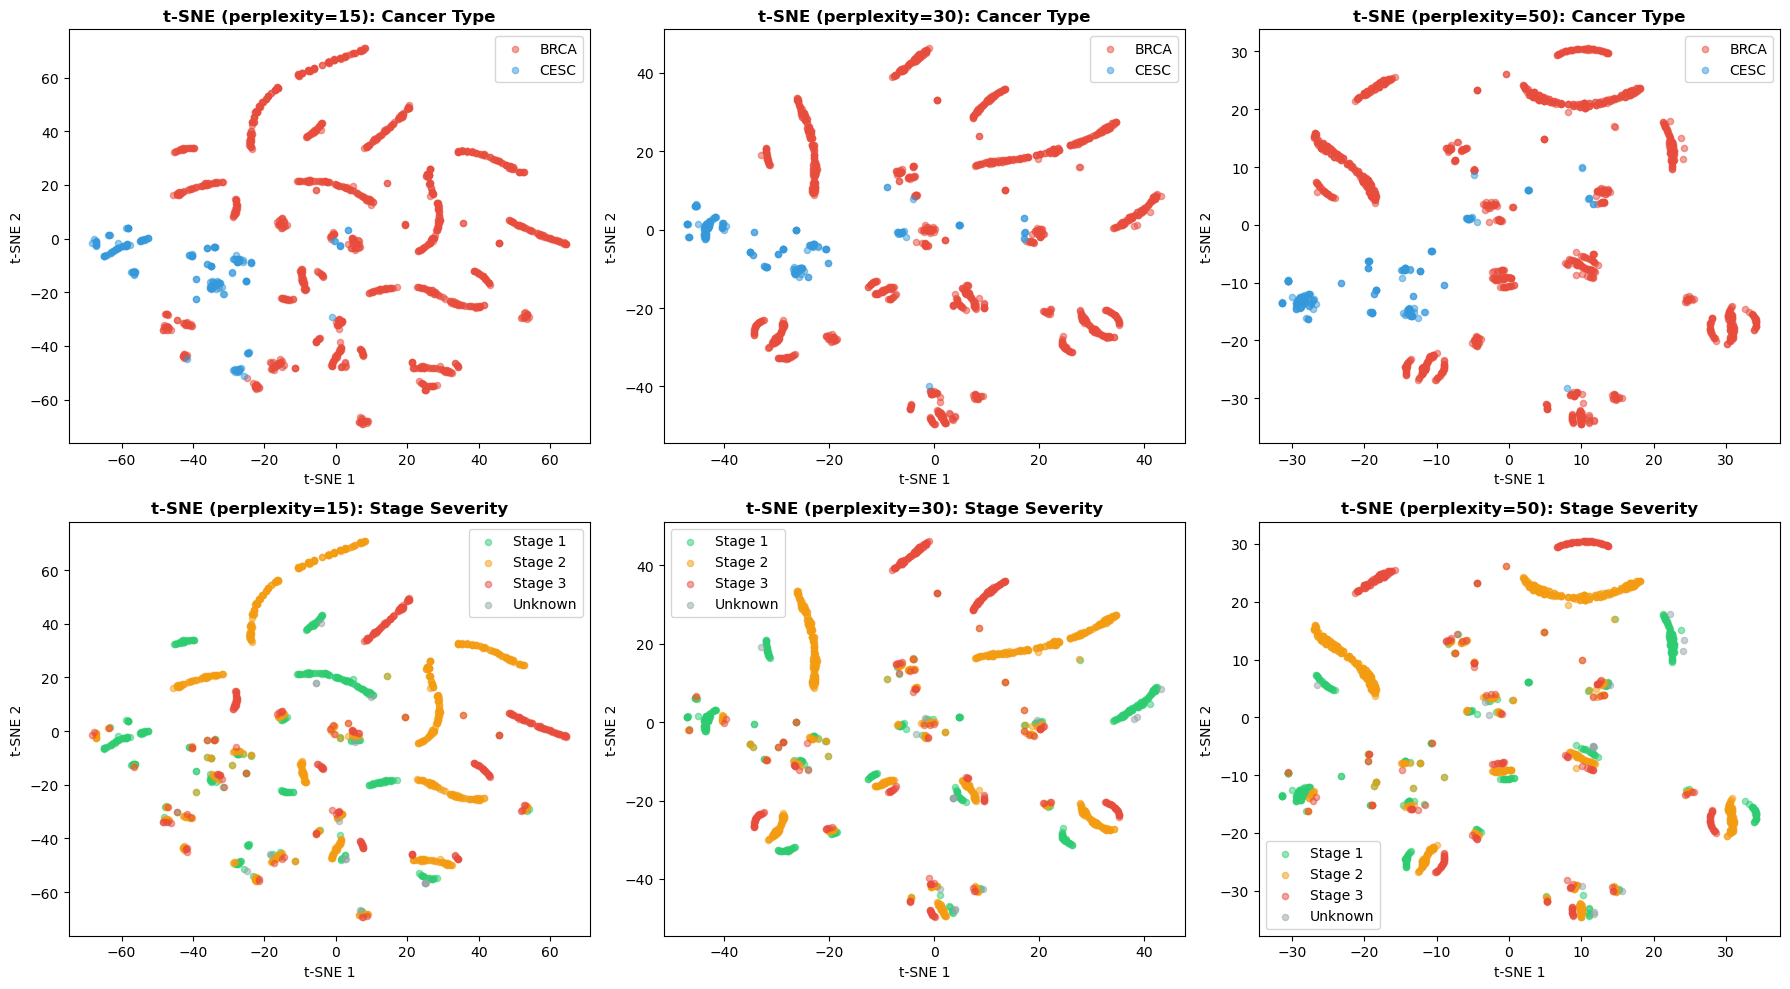

In [128]:
perplexities = [15, 30, 50]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=321, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    ax1 = axes[0, idx]
    for cancer in ['BRCA', 'CESC']:
        mask = y_cancer == cancer
        ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors_cancer[cancer], label=cancer, alpha=0.5, s=20)
    ax1.set_xlabel('t-SNE 1')
    ax1.set_ylabel('t-SNE 2')
    ax1.set_title(f't-SNE (perplexity={perp}): Cancer Type', fontweight='bold')
    ax1.legend()
    
    ax2 = axes[1, idx]
    for stage in [1, 2, 3, 4, 0]:
        mask = analysis_df['stage_severity'].values == stage
        if mask.sum() > 0:
            ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors_stage[stage], label=stage_labels[stage], alpha=0.5, s=20)
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_title(f't-SNE (perplexity={perp}): Stage Severity', fontweight='bold')
    ax2.legend()

plt.tight_layout()
plt.show()



### PCA vs t-SNE Comparison

| Aspect | PCA | t-SNE |
|--------|-----|-------|
| **Type** | Linear projection | Non-linear embedding |
| **Preserves** | Global variance | Local neighborhoods |
| **Interpretability** | High (loadings meaningful) | Low (axes arbitrary) |
| **Best for** | Feature importance, preprocessing | Visualization, cluster discovery |

# Clustering Methods

Three clustering methods were applied: K-means clustering, hierarchical clustering, and Density-Based Spatial Clustering(DBSCAN). The optimal number of clusters was evaluated using the silhouette score, Calinski–Harabasz index, and elbow analysis. Although these metrics consistently suggested an optimal value of k = 2, this separation primarily reflected cancer type, breast vs cervical. To explore additional heterogeneity, we selected k = 3 for interpretability. DBSCAN was used to identify potential outliers and detect non-spherical cluster structures, in contrast to K-means, which partitions patients into a fixed number of spherical clusters.

## K-Means Clustering
**Assumptions:** Spherical clusters, equal feature contribution (requires standardization)

**Model Selection:** We use silhouette score to evaluate cluster quality.


Selected optimal k: 3


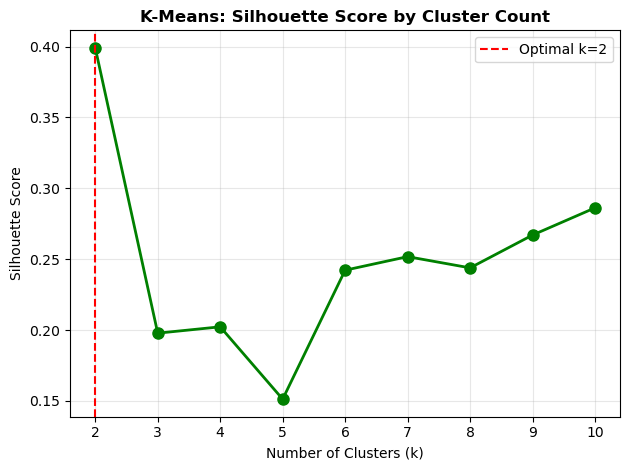

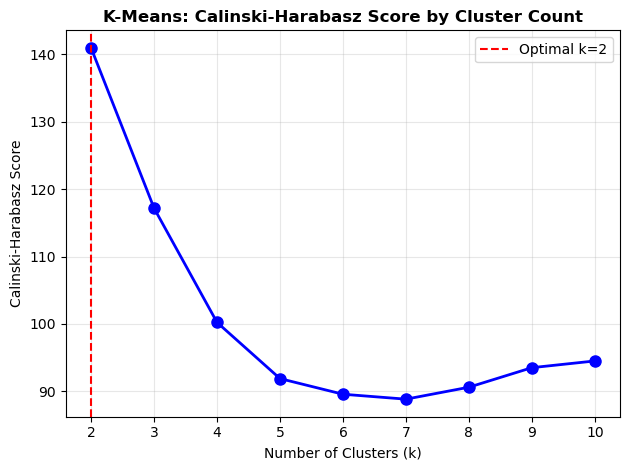

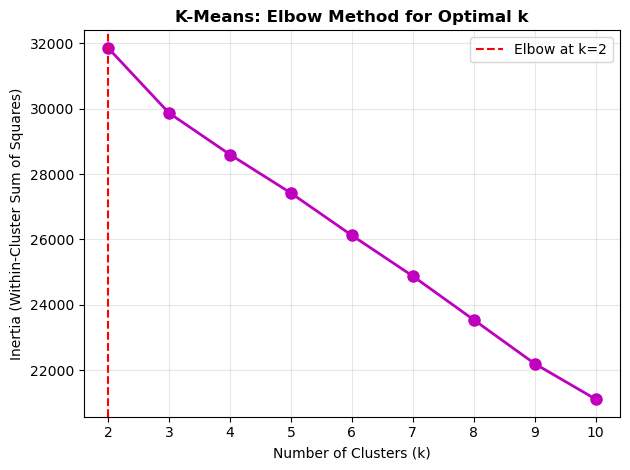

In [129]:
k_range = range(2, 11)
silhouette_scores = []
calinski_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]

inertia_series = pd.Series(inertias)
inertia_diff2 = inertia_series.diff().diff().dropna().values
optimal_k_elbow = k_range[np.argmax(np.abs(inertia_diff2))]

# Select final k
optimal_k_candidates = [optimal_k_silhouette, optimal_k_calinski, optimal_k_elbow]
optimal_k = 3
print(f"\nSelected optimal k: {optimal_k}")

# Silhouette Score
fig, ax = plt.subplots()
ax.plot(list(k_range), silhouette_scores, 'go-', linewidth=2, markersize=8)
ax.axvline(x=optimal_k_silhouette, color='r', linestyle='--', 
           label=f'Optimal k={optimal_k_silhouette}')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('K-Means: Silhouette Score by Cluster Count', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calinski-Harabasz Score
fig, ax = plt.subplots()
ax.plot(list(k_range), calinski_scores, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=optimal_k_calinski, color='r', linestyle='--', 
           label=f'Optimal k={optimal_k_calinski}')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Calinski-Harabasz Score')
ax.set_title('K-Means: Calinski-Harabasz Score by Cluster Count', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Elbow Method
fig, ax = plt.subplots()
ax.plot(list(k_range), inertias, 'mo-', linewidth=2, markersize=8)
ax.axvline(x=optimal_k_elbow, color='r', linestyle='--', 
           label=f'Elbow at k={optimal_k_elbow}')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)')
ax.set_title('K-Means: Elbow Method for Optimal k', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



K-Means Cluster distribution:
cluster
0    756
1    326
2    183
Name: count, dtype: int64


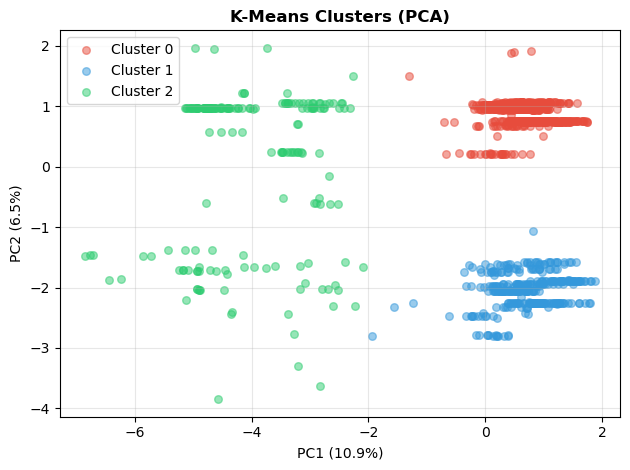

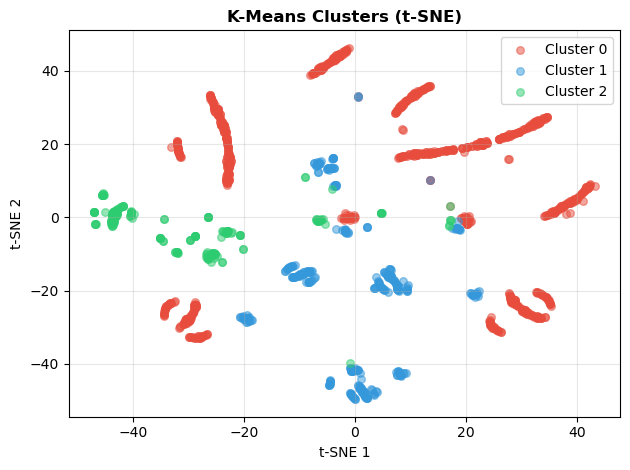

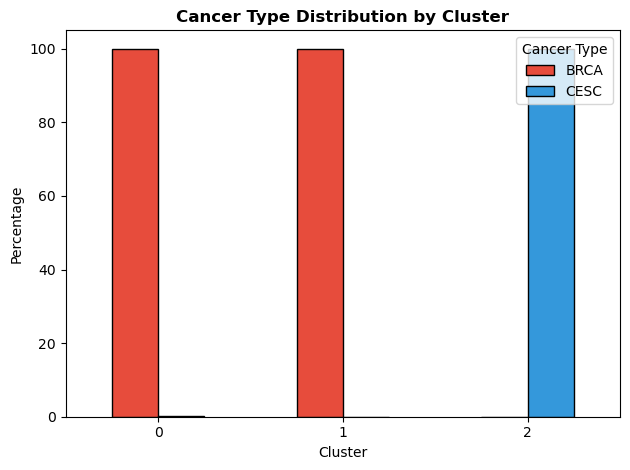

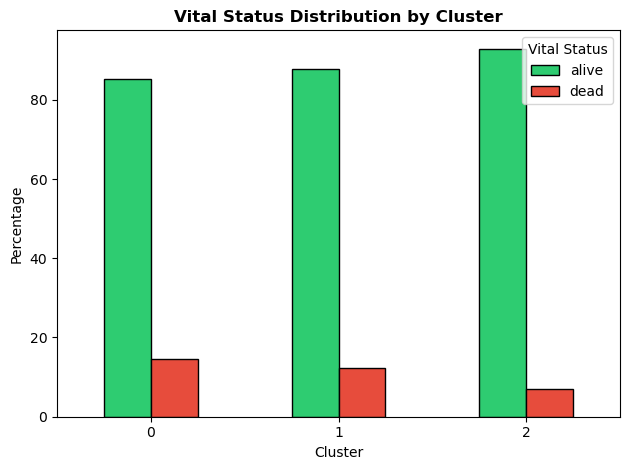

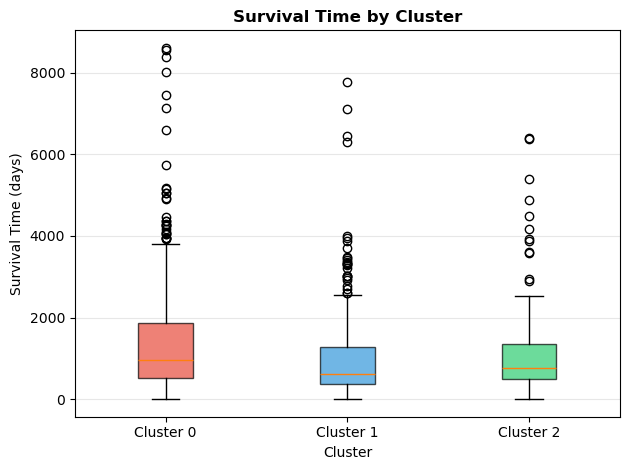

In [130]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
analysis_df['cluster'] = cluster_labels

print(f"\nK-Means Cluster distribution:")
print(analysis_df['cluster'].value_counts().sort_index())

base_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12']
cluster_colors = base_colors[:optimal_k]

fig, ax = plt.subplots()
for i in range(optimal_k):
    mask = cluster_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=cluster_colors[i], label=f'Cluster {i}', alpha=0.5, s=30)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)')
ax.set_title('K-Means Clusters (PCA)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
for i in range(optimal_k):
    mask = cluster_labels == i
    ax.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c=cluster_colors[i], label=f'Cluster {i}', alpha=0.5, s=30)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('K-Means Clusters (t-SNE)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
cluster_cancer = pd.crosstab(analysis_df['cluster'], analysis_df['cancer_type'], normalize='index') * 100
cluster_cancer.plot(kind='bar', ax=ax, color=['#E74C3C', '#3498DB'], edgecolor='black')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage')
ax.set_title('Cancer Type Distribution by Cluster', fontweight='bold')
ax.legend(title='Cancer Type')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
cluster_status = pd.crosstab(analysis_df['cluster'], analysis_df['demographic.vital_status'], normalize='index') * 100
cluster_status.plot(kind='bar', ax=ax, color=['#2ECC71', '#E74C3C'], edgecolor='black')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage')
ax.set_title('Vital Status Distribution by Cluster', fontweight='bold')
ax.legend(title='Vital Status')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
cluster_survival = [analysis_df[analysis_df['cluster'] == i]['survival_time_days'].values for i in range(optimal_k)]
bp = ax.boxplot(cluster_survival, patch_artist=True)
for patch, color in zip(bp['boxes'], cluster_colors[:optimal_k]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_xlabel('Cluster')
ax.set_ylabel('Survival Time (days)')
ax.set_title('Survival Time by Cluster', fontweight='bold')
ax.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Hierarchical Clustering


--- HIERARCHICAL CLUSTER PROFILES ---

HC Cluster 0 (n=382):
  Cancer Type: BRCA: 90.1%, CESC: 9.9%
  Mortality: 14.7%
  Mean Age: 57.9 years
  Dominant Stage: Stage 2

HC Cluster 1 (n=146):
  Cancer Type: CESC: 100.0%
  Mortality: 6.2%
  Mean Age: 47.4 years
  Dominant Stage: Stage 1

HC Cluster 2 (n=737):
  Cancer Type: BRCA: 100.0%
  Mortality: 13.4%
  Mean Age: 58.4 years
  Dominant Stage: Stage 2


Hierarchical Cluster distribution:
hc_cluster
0    382
1    146
2    737
Name: count, dtype: int64


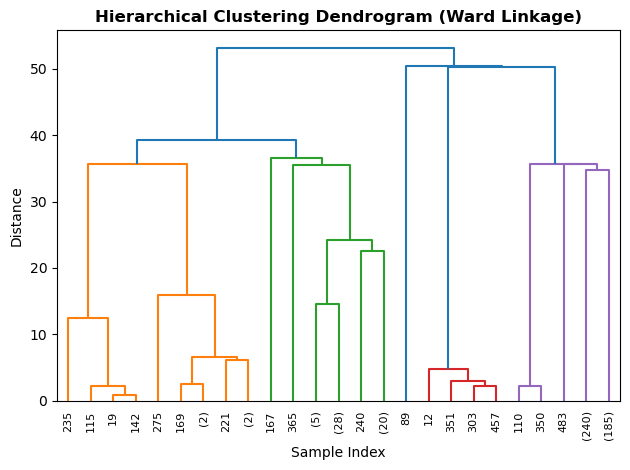

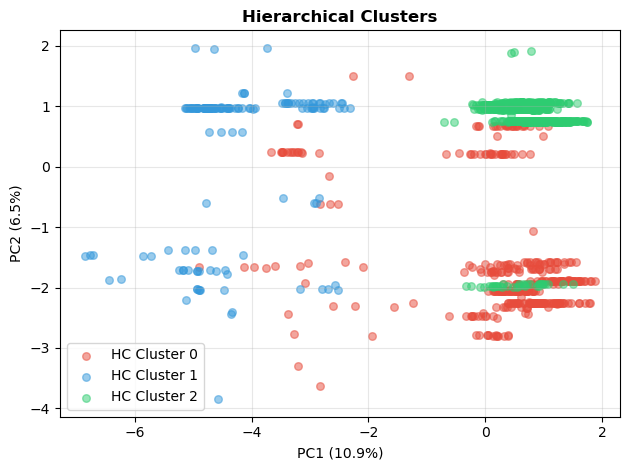

In [131]:
sample_size = min(500, len(X_scaled))
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]
linkage_matrix = linkage(X_sample, method='ward')
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)
analysis_df['hc_cluster'] = hc_labels

print("\n--- HIERARCHICAL CLUSTER PROFILES ---\n")
for hc_id in sorted(analysis_df['hc_cluster'].unique()):
    hc_data = analysis_df[analysis_df['hc_cluster'] == hc_id]
    print(f"HC Cluster {hc_id} (n={len(hc_data)}):")
    # Cancer type
    cancer_dist = hc_data['cancer_type'].value_counts(normalize=True) * 100
    cancer_str = ", ".join([f"{c}: {p:.1f}%" for c, p in cancer_dist.items()])
    print(f"  Cancer Type: {cancer_str}")
    # Mortality
    mortality = hc_data['is_deceased'].mean() * 100
    print(f"  Mortality: {mortality:.1f}%")
    # Age
    print(f"  Mean Age: {hc_data['diagnoses.age_at_diagnosis'].mean():.1f} years")
    # Stage
    stage_mode = hc_data['stage_severity'].mode().iloc[0]
    print(f"  Dominant Stage: {stage_labels.get(stage_mode, f'Stage {stage_mode}')}")
    print()

print(f"\nHierarchical Cluster distribution:")
print(analysis_df['hc_cluster'].value_counts().sort_index())

fig, ax = plt.subplots()
dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=8, color_threshold=0.7*max(linkage_matrix[:,2]))
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontweight='bold')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
hc_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12']
for i in sorted(analysis_df['hc_cluster'].unique()):
    mask = hc_labels == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=hc_colors[i], label=f'HC Cluster {i}', alpha=0.5, s=30)
ax.set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)')
ax.set_title('Hierarchical Clusters', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## DBSCAN
**Key hyperparameters:**
- `eps`: Maximum distance between neighbors
- `min_samples`: Minimum points to form a dense region

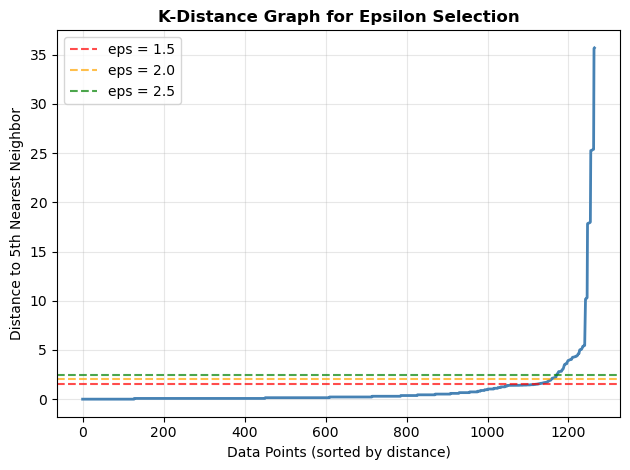


DBSCAN Parameter Comparison:
 eps  min_samples  n_clusters  n_noise  noise_pct  silhouette
 1.5            5          25      111      8.775       0.582
 2.0            5          26       94      7.431       0.579
 2.5            5          25       81      6.403       0.479
 2.0           10          21      135     10.672       0.584
 2.5           10          21      107      8.458       0.480
 3.0           10          20       93      7.352       0.466

Cluster Distribution:
-1     135
 0     218
 1      64
 2      54
 3     279
 4      91
 5     108
 6      14
 7      20
 8      24
 9      15
 10     24
 11     47
 12     17
 13     16
 14     13
 15     15
 16     11
 17     20
 18     53
 19     13
 20     14
Name: count, dtype: int64


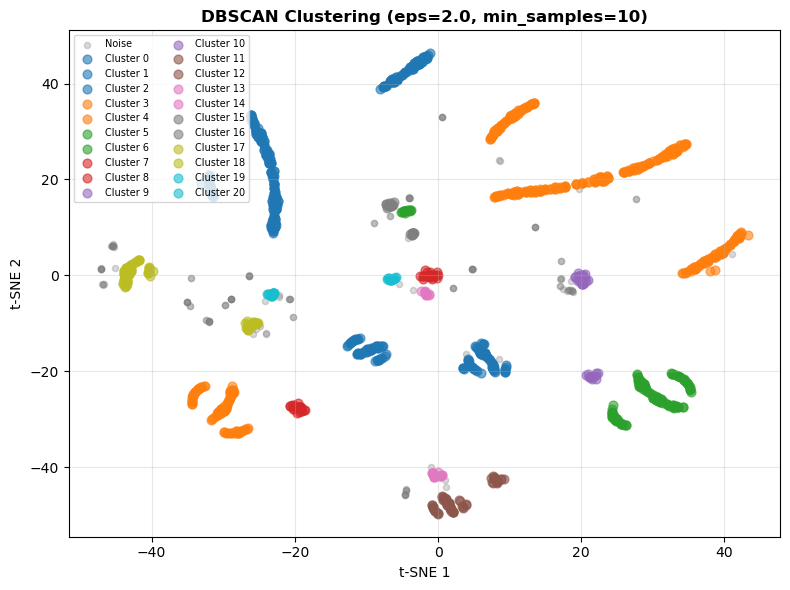

In [132]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

fig, ax = plt.subplots()
ax.plot(distances, color='steelblue', linewidth=2)
ax.set_xlabel('Data Points (sorted by distance)')
ax.set_ylabel('Distance to 5th Nearest Neighbor')
ax.set_title('K-Distance Graph for Epsilon Selection', fontweight='bold')

for eps_val, color in [(1.5, 'red'), (2.0, 'orange'), (2.5, 'green')]:
    ax.axhline(y=eps_val, color=color, linestyle='--', alpha=0.7, label=f'eps = {eps_val}')

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

param_combinations = [
    {'eps': 1.5, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 5},
    {'eps': 2.5, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 10},
    {'eps': 2.5, 'min_samples': 10},
    {'eps': 3.0, 'min_samples': 10}
]

dbscan_results = []

for params in param_combinations:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = n_noise / len(X_scaled) * 100
    
    sil_score = np.nan
    if n_clusters > 1 and noise_pct < 50:
        valid_mask = labels != -1
        if sum(valid_mask) > 50:
            sil_score = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
    
    dbscan_results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': sil_score
    })

dbscan_df = pd.DataFrame(dbscan_results)
print("\nDBSCAN Parameter Comparison:")
print(dbscan_df.round(3).to_string(index=False))

valid_results = dbscan_df[(dbscan_df['n_clusters'] >= 2) & (dbscan_df['noise_pct'] < 30)]

if len(valid_results) > 0:
    best_idx = valid_results['silhouette'].idxmax()
    best_params = dbscan_df.loc[best_idx]
else:
    best_idx = dbscan_df['n_clusters'].idxmax()
    best_params = dbscan_df.loc[best_idx]

dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
dbscan_labels = dbscan_final.fit_predict(X_scaled)
analysis_df['dbscan_cluster'] = dbscan_labels

print(f"\nCluster Distribution:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

unique_labels = sorted(set(dbscan_labels))
n_clusters = len([l for l in unique_labels if l != -1])
colors_dbscan = plt.cm.tab10(np.linspace(0, 1, max(10, n_clusters + 1)))

fig, ax = plt.subplots(figsize=(8, 6))

for label in unique_labels:
    mask = dbscan_labels == label
    if label == -1:
        ax.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c='gray', s=20, alpha=0.3, label='Noise')
    else:
        ax.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c=[colors_dbscan[label]], s=40, alpha=0.6, label=f'Cluster {label}')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'DBSCAN Clustering (eps={best_params["eps"]}, min_samples={int(best_params["min_samples"])})', fontweight='bold')
ax.legend(loc='best', fontsize=7, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Method Comparison

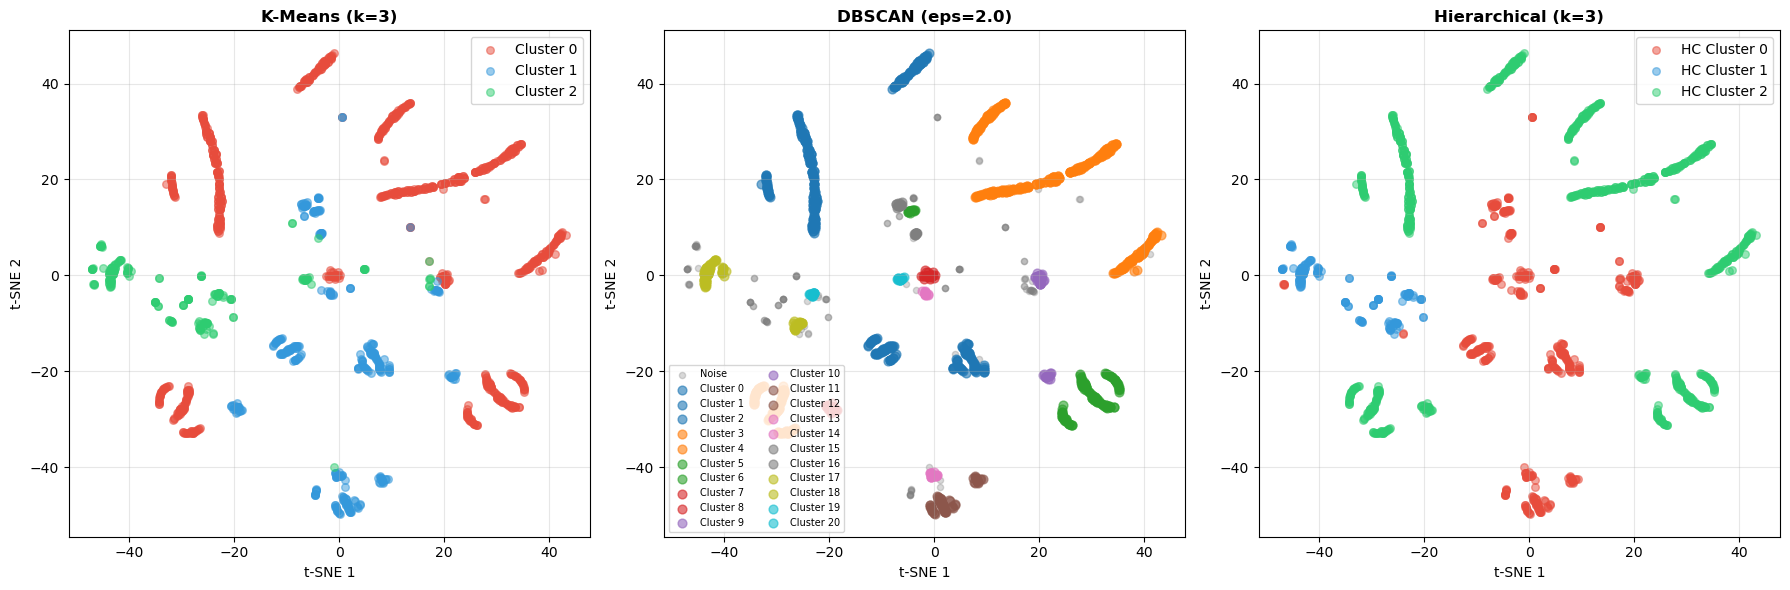


Method Comparison:
Method          Clusters   Noise      Silhouette  
-----------------------------------------------
K-Means         3          0          0.1978
Hierarchical    3          0          0.2060
DBSCAN          21         135        0.5837


In [133]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means
ax1 = axes[0]
for i in range(optimal_k):
    mask = cluster_labels == i
    ax1.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c=cluster_colors[i], label=f'Cluster {i}', alpha=0.5, s=30)
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.set_title(f'K-Means (k={optimal_k})', fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# DBSCAN
ax2 = axes[1]
for label in unique_labels:
    mask = dbscan_labels == label
    if label == -1:
        ax2.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c='gray', s=20, alpha=0.3, label='Noise')
    else:
        ax2.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c=[colors_dbscan[label]], s=40, alpha=0.6, label=f'Cluster {label}')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title(f'DBSCAN (eps={best_params["eps"]})', fontweight='bold')
ax2.legend(loc='best', fontsize=7, ncol=2)
ax2.grid(True, alpha=0.3)

# Hierarchical
ax3 = axes[2]
hc_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12']
for i in sorted(analysis_df['hc_cluster'].unique()):
    mask = hc_labels == i
    ax3.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], c=hc_colors[i], label=f'HC Cluster {i}', alpha=0.5, s=30)
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')
ax3.set_title(f'Hierarchical (k={optimal_k})', fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Method Comparison Table
print("\nMethod Comparison:")
print(f"{'Method':<15} {'Clusters':<10} {'Noise':<10} {'Silhouette':<12}")
print("-" * 47)
print(f"{'K-Means':<15} {optimal_k:<10} {'0':<10} {silhouette_score(X_scaled, cluster_labels):.4f}")
print(f"{'Hierarchical':<15} {optimal_k:<10} {'0':<10} {silhouette_score(X_scaled, hc_labels):.4f}")
if not np.isnan(best_params['silhouette']):
    print(f"{'DBSCAN':<15} {int(best_params['n_clusters']):<10} {int(best_params['n_noise']):<10} {best_params['silhouette']:.4f}")

## Cluster Profiling

In [134]:
for cluster_id in range(optimal_k):
    cluster_data = analysis_df[analysis_df['cluster'] == cluster_id]
    
    print(f"\n{'='*40}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)})")
    print('='*40)
    
    cancer_dist = cluster_data['cancer_type'].value_counts(normalize=True) * 100
    print(f"\nCancer Type Distribution:")
    for cancer, pct in cancer_dist.items():
        print(f"  {cancer}: {pct:.1f}%")
    
    vital_dist = cluster_data['demographic.vital_status'].value_counts(normalize=True) * 100
    print(f"\nVital Status:")
    for status, pct in vital_dist.items():
        print(f"  {status}: {pct:.1f}%")
    
    mortality_rate = cluster_data['is_deceased'].mean() * 100
    print(f"\nMortality Rate: {mortality_rate:.1f}%")
    
    age_mean = cluster_data['diagnoses.age_at_diagnosis'].mean()
    age_std = cluster_data['diagnoses.age_at_diagnosis'].std()
    print(f"\nAge at Diagnosis: {age_mean:.1f} +/- {age_std:.1f} years")
    
    surv_mean = cluster_data['survival_time_days'].mean()
    surv_median = cluster_data['survival_time_days'].median()
    print(f"\nSurvival Time: Mean={surv_mean:.0f} days, Median={surv_median:.0f} days")
    
    stage_dist = cluster_data['stage_severity'].value_counts(normalize=True) * 100
    print(f"\nStage Severity:")
    for stage, pct in stage_dist.items():
        print(f"  {stage_labels.get(stage, f'Stage {stage}')}: {pct:.1f}%")


CLUSTER 0 (n=756)

Cancer Type Distribution:
  BRCA: 99.9%
  CESC: 0.1%

Vital Status:
  alive: 85.3%
  dead: 14.7%

Mortality Rate: 14.7%

Age at Diagnosis: 58.6 +/- 12.9 years

Survival Time: Mean=1338 days, Median=971 days

Stage Severity:
  Stage 2: 55.4%
  Stage 3: 23.3%
  Stage 1: 20.5%
  Unknown: 0.8%

CLUSTER 1 (n=326)

Cancer Type Distribution:
  BRCA: 100.0%

Vital Status:
  alive: 87.7%
  dead: 12.3%

Mortality Rate: 12.3%

Age at Diagnosis: 58.6 +/- 13.7 years

Survival Time: Mean=1023 days, Median=628 days

Stage Severity:
  Stage 2: 59.5%
  Stage 3: 21.8%
  Stage 1: 16.0%
  Unknown: 2.8%

CLUSTER 2 (n=183)

Cancer Type Distribution:
  CESC: 100.0%

Vital Status:
  alive: 92.9%
  dead: 7.1%

Mortality Rate: 7.1%

Age at Diagnosis: 47.4 +/- 12.1 years

Survival Time: Mean=1082 days, Median=761 days

Stage Severity:
  Stage 1: 63.9%
  Stage 2: 24.6%
  Stage 3: 11.5%


In [135]:
summary_data = []
for cluster_id in range(optimal_k):
    cluster_data = analysis_df[analysis_df['cluster'] == cluster_id]
    cancer_mode = cluster_data['cancer_type'].mode().iloc[0]
    cancer_pct = (cluster_data['cancer_type'] == cancer_mode).mean() * 100
    stage_mode = cluster_data['stage_severity'].mode().iloc[0]
    
    summary_data.append({
        'Cluster': cluster_id,
        'n': len(cluster_data),
        'Cancer': f"{cancer_mode} ({cancer_pct:.0f}%)",
        'Mortality': f"{cluster_data['is_deceased'].mean()*100:.1f}%",
        'Age': f"{cluster_data['diagnoses.age_at_diagnosis'].mean():.1f}y",
        'Survival': f"{cluster_data['survival_time_days'].mean():.0f}d",
        'Stage': stage_labels.get(stage_mode, f'Stage {stage_mode}')
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

 Cluster   n      Cancer Mortality   Age Survival   Stage
       0 756 BRCA (100%)     14.7% 58.6y    1338d Stage 2
       1 326 BRCA (100%)     12.3% 58.6y    1023d Stage 2
       2 183 CESC (100%)      7.1% 47.4y    1082d Stage 1


## Feature Importance


Top 15 Features for Cluster Separation:
  Treated:True: 1.3137
  Treated:yes: 1.3100
  Race:white: 0.9057
  TxType:hysterectomy, nos: 0.8239
  Race:black or african american: 0.6670
  Race:not reported: 0.4692
  Age: 0.3872
  TxType:surgery, nos: 0.3828
  Stage: 0.3510
  Race:unknown: 0.3320
  Race:asian: 0.2785
  TxType:radiation, 3d conformal: 0.2758
  TxType:radiation, internal: 0.2431
  Treated:no: 0.2250
  TxType:brachytherapy, high dose: 0.2053


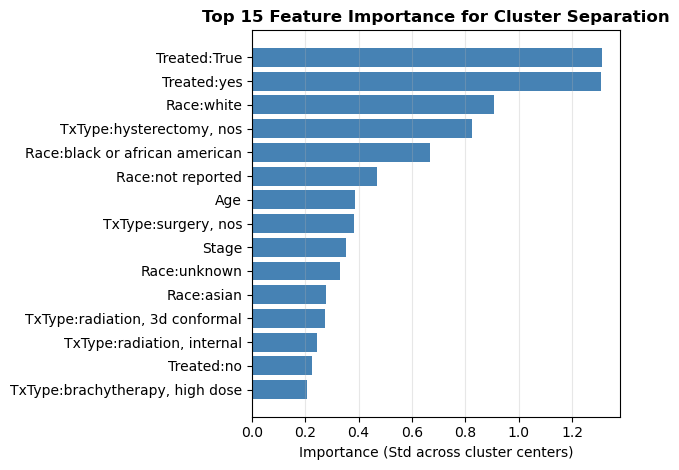

In [136]:
cluster_centers = kmeans.cluster_centers_
feature_importance = np.std(cluster_centers, axis=0)

top_n = 15
top_idx = np.argsort(feature_importance)[-top_n:][::-1]

print(f"\nTop {top_n} Features for Cluster Separation:")
for i in top_idx:
    print(f"  {feature_names_short[i]}: {feature_importance[i]:.4f}")
    
fig, ax = plt.subplots()
top_importance = feature_importance[top_idx]
top_names = [feature_names_short[i] for i in top_idx]

ax.barh(range(top_n), top_importance[::-1], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_names[::-1])
ax.set_xlabel('Importance (Std across cluster centers)')
ax.set_title('Top 15 Feature Importance for Cluster Separation', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Statistical Validation

In [137]:
for cancer in ['BRCA', 'CESC']:
    cancer_data = analysis_df[analysis_df['cancer_type'] == cancer]
    n_total = len(cancer_data)
    n_deaths = cancer_data['is_deceased'].sum()
    mortality = (n_deaths / n_total) * 100
    print(f"{cancer}: {n_deaths}/{n_total} deaths ({mortality:.1f}%)")

contingency = pd.crosstab(analysis_df['cancer_type'], analysis_df['is_deceased'])
print("\nContingency Table:")
print(contingency)

chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")
if p_value < 0.05:
    print("Result: Mortality difference IS statistically significant")
else:
    print("Result: Mortality difference is NOT statistically significant")

BRCA: 151/1081 deaths (14.0%)
CESC: 13/184 deaths (7.1%)

Contingency Table:
is_deceased    0    1
cancer_type          
BRCA         930  151
CESC         171   13

Chi-square: 6.0431
P-value: 0.013961
Result: Mortality difference IS statistically significant


In [138]:
brca_survival = analysis_df[analysis_df['cancer_type'] == 'BRCA']['survival_time_days']
cesc_survival = analysis_df[analysis_df['cancer_type'] == 'CESC']['survival_time_days']

print(f"BRCA: Mean={brca_survival.mean():.0f}d, Median={brca_survival.median():.0f}d, n={len(brca_survival)}")
print(f"CESC: Mean={cesc_survival.mean():.0f}d, Median={cesc_survival.median():.0f}d, n={len(cesc_survival)}")

stat, p_value_surv = mannwhitneyu(brca_survival, cesc_survival, alternative='two-sided')
print(f"\nMann-Whitney U p-value: {p_value_surv:.6f}")
if p_value_surv < 0.05:
    print("Result: Survival time difference IS statistically significant")
else:
    print("Result: Survival time difference is NOT statistically significant")

BRCA: Mean=1244d, Median=856d, n=1081
CESC: Mean=1076d, Median=758d, n=184

Mann-Whitney U p-value: 0.138011
Result: Survival time difference is NOT statistically significant


In [139]:
deceased_df = analysis_df[analysis_df['is_deceased'] == 1].copy()

print(f"Deceased patients:")
print(f"  BRCA: {len(deceased_df[deceased_df['cancer_type']=='BRCA'])} patients")
print(f"  CESC: {len(deceased_df[deceased_df['cancer_type']=='CESC'])} patients")

brca_death_times = deceased_df[deceased_df['cancer_type']=='BRCA']['survival_time_days']
cesc_death_times = deceased_df[deceased_df['cancer_type']=='CESC']['survival_time_days']

print(f"\nSurvival time among deceased patients:")
print(f"  BRCA deceased: Mean={brca_death_times.mean():.0f}d, Median={brca_death_times.median():.0f}d")
print(f"  CESC deceased: Mean={cesc_death_times.mean():.0f}d, Median={cesc_death_times.median():.0f}d")

stat_deceased, p_deceased = mannwhitneyu(brca_death_times, cesc_death_times, alternative='two-sided')
print(f"\nMann-Whitney U (deceased only): p={p_deceased:.4f}")
if p_deceased < 0.05:
    print("-> CESC patients die significantly earlier when they do die")

Deceased patients:
  BRCA: 151 patients
  CESC: 13 patients

Survival time among deceased patients:
  BRCA deceased: Mean=1585d, Median=1152d
  CESC deceased: Mean=668d, Median=492d

Mann-Whitney U (deceased only): p=0.0032
-> CESC patients die significantly earlier when they do die


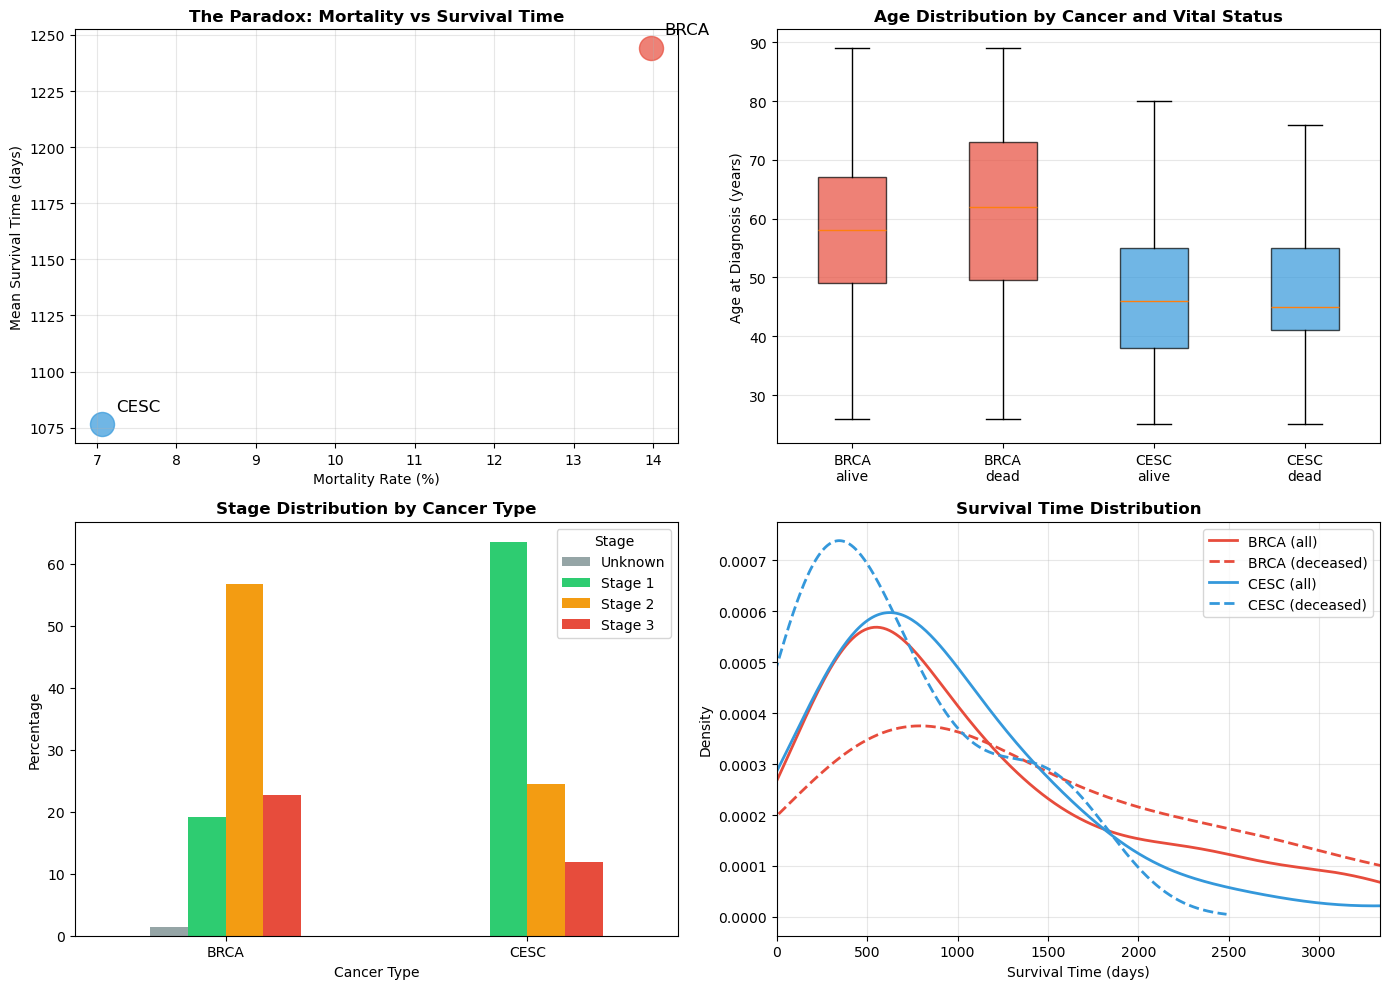

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
cancer_stats = analysis_df.groupby('cancer_type').agg({'is_deceased': 'mean', 'survival_time_days': 'mean'}).reset_index()
for idx, row in cancer_stats.iterrows():
    ax1.scatter(row['is_deceased']*100, row['survival_time_days'], s=300, alpha=0.7, color=colors_cancer[row['cancer_type']])
    ax1.annotate(row['cancer_type'], (row['is_deceased']*100, row['survival_time_days']), xytext=(10, 10), textcoords='offset points', fontsize=12)
ax1.set_xlabel('Mortality Rate (%)')
ax1.set_ylabel('Mean Survival Time (days)')
ax1.set_title('The Paradox: Mortality vs Survival Time', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
age_data = []
box_labels = []
box_colors = []
for cancer in ['BRCA', 'CESC']:
    for status in ['alive', 'dead']:
        mask = (analysis_df['cancer_type'] == cancer) & (analysis_df['demographic.vital_status'].str.lower() == status)
        age_data.append(analysis_df.loc[mask, 'diagnoses.age_at_diagnosis'].values)
        box_labels.append(f'{cancer}\n{status}')
        box_colors.append(colors_cancer[cancer])

bp = ax2.boxplot(age_data, patch_artist=True)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xticklabels(box_labels)
ax2.set_ylabel('Age at Diagnosis (years)')
ax2.set_title('Age Distribution by Cancer and Vital Status', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

ax3 = axes[1, 0]
stage_comparison = pd.crosstab(analysis_df['cancer_type'], analysis_df['stage_severity'], normalize='index') * 100
stage_comparison.plot(kind='bar', ax=ax3, color=[colors_stage[i] for i in stage_comparison.columns])
ax3.set_xlabel('Cancer Type')
ax3.set_ylabel('Percentage')
ax3.set_title('Stage Distribution by Cancer Type', fontweight='bold')
ax3.tick_params(axis='x', rotation=0)
ax3.legend(title='Stage', labels=[stage_labels.get(s, f'Stage {s}') for s in stage_comparison.columns])

ax4 = axes[1, 1]
for cancer in ['BRCA', 'CESC']:
    cancer_data = analysis_df[analysis_df['cancer_type'] == cancer]['survival_time_days']
    cancer_data_deceased = analysis_df[(analysis_df['cancer_type'] == cancer) & (analysis_df['is_deceased'] == 1)]['survival_time_days']
    cancer_data.plot.kde(ax=ax4, label=f'{cancer} (all)', color=colors_cancer[cancer], linewidth=2)
    if len(cancer_data_deceased) > 1:
        cancer_data_deceased.plot.kde(ax=ax4, label=f'{cancer} (deceased)', color=colors_cancer[cancer], linewidth=2, linestyle='--')

ax4.set_xlabel('Survival Time (days)')
ax4.set_ylabel('Density')
ax4.set_title('Survival Time Distribution', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, analysis_df['survival_time_days'].quantile(0.95))

plt.tight_layout()
plt.show()

# Results 

Dimensionality reduction revealed substantial heterogeneity in the combined clinical dataset. PCA showed that no single principal component dominated variance, with only 10.95% of variance explained by the first component and 18 components required to reach 80% cumulative variance. This indicates that patient variation is distributed across multiple clinical factors rather than driven by a single dominant feature. PCA visualizations demonstrated partial overlap between breast (BRCA) and cervical (CESC) cancer patients, while t-SNE revealed clearer local structure, particularly with respect to cancer type and disease stage.

K-Means clustering identified three clinically interpretable patient groups. Two clusters consisted almost entirely of BRCA patients, differing modestly in survival time and mortality despite similar age and stage distributions. The third cluster was composed exclusively of CESC patients and was characterized by younger age at diagnosis, earlier stage disease, and lower overall mortality. Hierarchical clustering produced a similar structure, reinforcing the stability of the observed subgroup patterns. DBSCAN identified many small, dense clusters and a subset of noise points, suggesting high local heterogeneity but reduced interpretability for population-level comparisons.

Mortality analysis showed a statistically significant difference in overall mortality rates between cancers (BRCA: 14.0%, CESC: 7.1%; χ² p = 0.014). Mean and median survival times across all patients did not differ significantly between cancers; however, among deceased patients only, cervical cancer patients died significantly earlier than breast cancer patients (median 492 vs. 1152 days; p = 0.003). This highlights a mortality paradox in which cervical cancer patients experience lower overall mortality but more rapid progression among fatal cases.

Feature importance analysis indicated that treatment indicators, race, age, and stage severity were the strongest contributors to cluster separation, suggesting that both clinical severity and treatment pathways play key roles in defining patient subgroups.

# Conclusion

This study applied unsupervised learning methods to identify clinically meaningful patient subgroups within breast and cervical cancer cohorts using TCGA clinical data. Results demonstrate that patient heterogeneity is high and cannot be captured by a small number of linear dimensions. Clustering consistently separated patients by cancer type, age, stage severity, and treatment patterns, with cervical cancer patients forming a distinct subgroup characterized by earlier stage disease and lower overall mortality.

Importantly, post-clustering survival analysis revealed a nuanced mortality pattern: while cervical cancer patients were less likely to die overall, those who did experienced significantly shorter survival times. This finding underscores the importance of separating incidence, mortality risk, and time-to-death when interpreting cancer outcomes.

Overall, this analysis highlights the value of unsupervised learning for exploratory clinical stratification and demonstrates how combining clustering with careful post hoc outcome analysis can yield insights into cancer progression while avoiding outcome-driven bias.